# First part: ridge regression

In [517]:
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import numpy as np
import math
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn import decomposition
from scipy.stats.stats import pearsonr  
from numpy import linalg

## Ridge regression

Ridge regression is a type of regression that introduces the concept of regularization through the alpha parameter in the ERM; at the end of this project we will see how to calibrate the value of this parameter

A regressor is a function

<img src = "images/regressor.png" width = "200">

 where <em>w</em> is a vector of real coefficients (weights), and <em>x</em> refers to the <em>x</em> component of training set

As anticipated before, the ERM is regularized by parameter <b>$\alpha$</b>

<img src= "images/ridge_regression.png" width = "350"/>

where S is the <b>design matrix</b>, the matrix of examples without labels

$\nabla(\left \| Sw - y \right \|^2 + \alpha \left \| w \right \|^2) = 2(S^TSw - S^Ty) + 2\alpha w$

since we want to minimize this function, let's set it equal to 0 and we obtain

$(S^TS + \alpha I)w = S^Ty$

$w = (S^TS + \alpha I)^{-1} S^Ty$

The regularization is needed since, without it, the vector is unstable; in particular, it can change a lot when the dataset is perturbed and let's keep in mind that we had to deal with missing values, hence we changed a fex examples and this could have led to a variance error.

### Estimator

In [518]:
class myRidgeRegressor(object):
    def __init__(self):
        pass
    
    def fit(self, S, y, alfa):
        self.w = linalg.inv(S.T.dot(S) + alfa * np.eye(S.shape[1])).dot(S.T.dot(y))
    
    def predict(self, x):
        return x.dot(self.w)

In [519]:
def square_loss(prediction, y):
    return (y - prediction) ** 2

In [520]:
def MSE(prediction, y):
    loss = square_loss(prediction, y)
    return 1/len(loss) * sum(loss)

### Loading preprocessed datasets

Let's load the preprocessed datasets, we will handle 4 cases:
1. the complete dataset with replaced missing values normalized with min-max
2. the reduced dataset (missing values have been removed) with min-max normalization
3. the complete dataset with z-score normalization
4. the reduced dataset normalized with z-score

In [521]:
min_max_norm_dataset = pd.read_csv("datasets/min_max_norm_dataset")
min_max_norm_reduced_dataset = pd.read_csv("datasets/min_max_norm_reduced_dataset")

zscore_norm_dataset = pd.read_csv("datasets/zscore_norm_dataset")
zscore_norm_reduced_dataset = pd.read_csv("datasets/zscore_norm_reduced_dataset")

In [522]:
del min_max_norm_dataset["Unnamed: 0"]
del min_max_norm_reduced_dataset["Unnamed: 0"]
del zscore_norm_dataset["Unnamed: 0"]
del zscore_norm_reduced_dataset["Unnamed: 0"]

### Splitting in training and test set

In [523]:
def simple_split(dataset):
    y = dataset["median_house_value"]
    x = dataset.drop("median_house_value", axis = 1)
    return x, y

def split_dataset(dataset): # this splits also x and y into train and test sets randomly
    x, y = simple_split(dataset)
    return train_test_split(x, y, shuffle = True, test_size = 0.2)

Now we apply the ridge regressor for the 4 datasets and compute predictions, for this part it will be used $\alpha$ = 0.1

In [524]:
ridge_regressor = myRidgeRegressor()

### First dataset

In [525]:
min_max_norm_dataset = min_max_norm_dataset.sample(frac=1).reset_index(drop=True)
x_train, x_test, y_train, y_test = split_dataset(min_max_norm_dataset)

We fit the regressor with the training set, we obtain a w vector of weights that depends on alpha parameter

In [526]:
ridge_regressor.fit(x_train, y_train, 0.1)
ridge_regressor.w

array([-0.15520873, -0.09503387,  0.14744805, -0.36862882,  0.56373155,
       -0.81322995,  0.19458773,  0.75655217,  0.21640208])

and we can test the regressor on the test set to see how good predictions are done

In [527]:
predictions = ridge_regressor.predict(x_test)
predictions[:10]

6835     0.378973
15891    0.393012
6805     0.585864
4271     0.162396
1209     0.609010
12059    0.202594
6039     0.304145
5699     0.303655
4530     0.316395
8553     0.586283
dtype: float64

In [528]:
loss = square_loss(predictions, y_test)

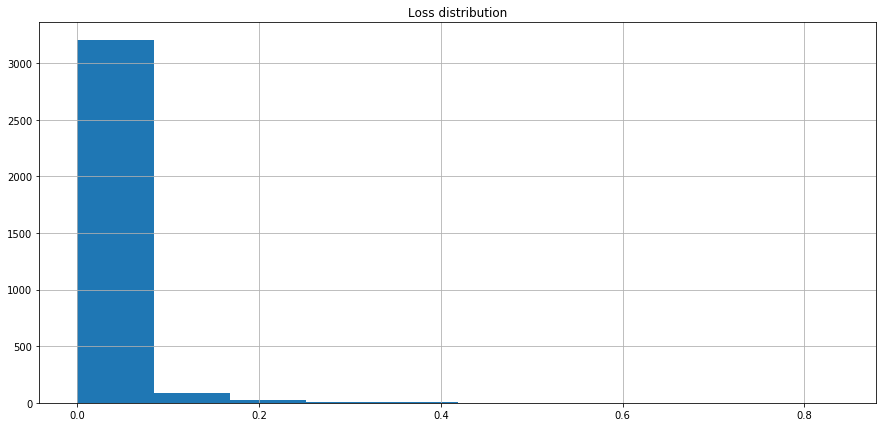

In [529]:
plt.figure(figsize=(15, 7))
plt.title('Loss distribution')
plt.hist(loss.values)
plt.grid()
plt.show()

In [530]:
test_error = MSE(predictions, y_test)
test_error

0.017598952682038798

In [531]:
r2_score(y_test, predictions)

0.5933199612293378

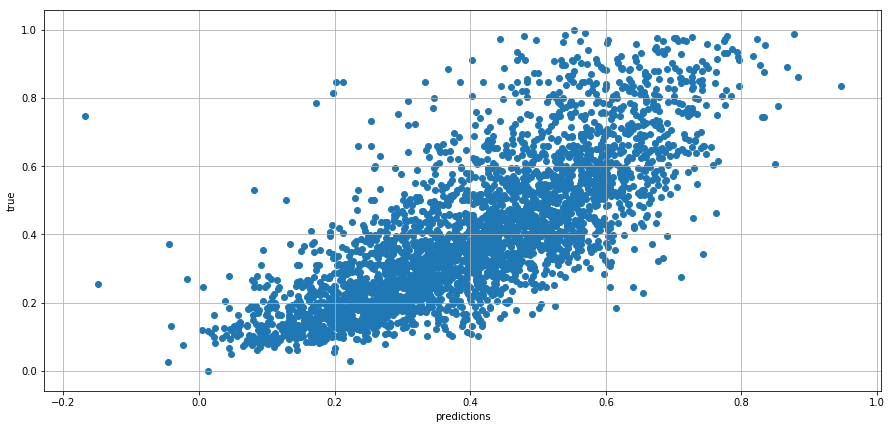

In [532]:
plt.figure(figsize=(15, 7))
plt.scatter(predictions, y_test)
plt.xlabel("predictions")
plt.ylabel("true")
plt.grid()
plt.show()

### Second dataset

In [533]:
min_max_norm_reduced_dataset = min_max_norm_reduced_dataset.sample(frac=1).reset_index(drop=True)
x_train, x_test, y_train, y_test = split_dataset(min_max_norm_reduced_dataset)

In [534]:
ridge_regressor.fit(x_train, y_train, 0.1)
ridge_regressor.w

array([-0.15866474, -0.0948915 ,  0.15109111, -0.36029216,  0.49422005,
       -0.82471881,  0.19678956,  0.75272981,  0.21579023])

In [535]:
predictions = ridge_regressor.predict(x_test)
predictions[:10]

15789    0.400741
10234    0.483385
3724     0.585103
8971     0.697694
12240   -0.011418
11025    0.528176
5366     0.576396
66       0.567038
16165    0.429777
3951     0.547201
dtype: float64

In [536]:
loss = square_loss(predictions, y_test)

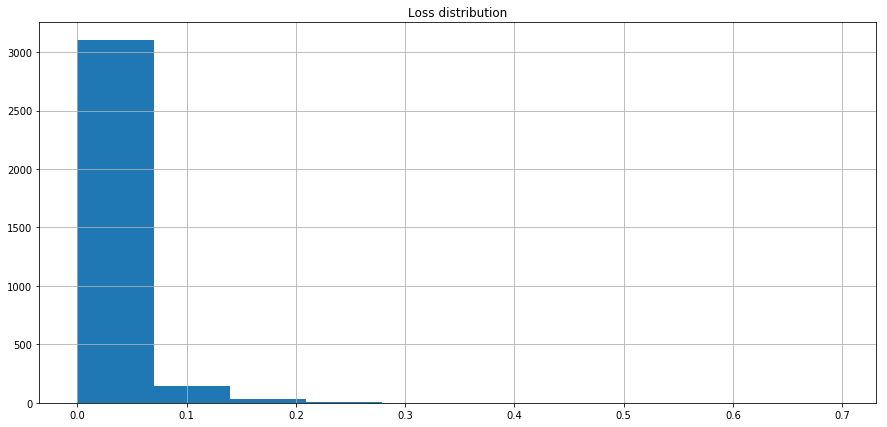

In [537]:
plt.figure(figsize=(15, 7))
plt.title('Loss distribution')
plt.hist(loss.values)
plt.grid()
plt.show()

In [538]:
test_error = MSE(predictions, y_test)
test_error

0.01812151271760806

In [539]:
r2_score(y_test, predictions)

0.6083700962443337

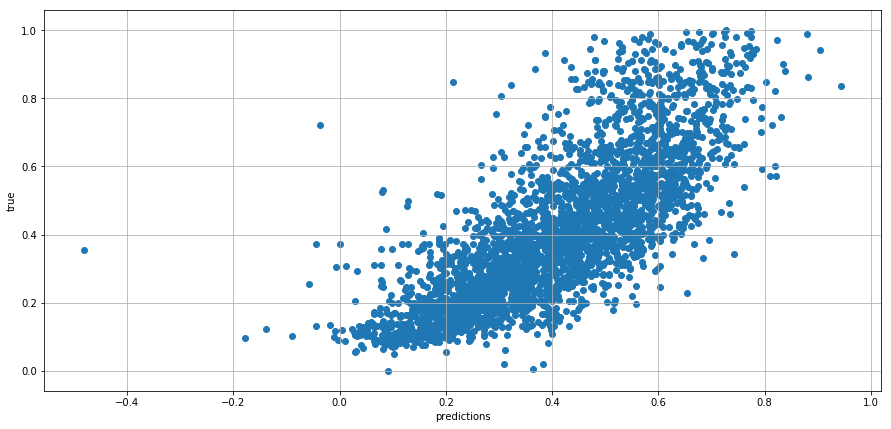

In [540]:
plt.figure(figsize=(15, 7))
plt.scatter(predictions, y_test)
plt.xlabel("predictions")
plt.ylabel("true")
plt.grid()
plt.show()

### Third dataset

In [541]:
zscore_norm_dataset = zscore_norm_dataset.sample(frac=1).reset_index(drop=True)
x_train, x_test, y_train, y_test = split_dataset(zscore_norm_dataset)

In [542]:
ridge_regressor.fit(x_train, y_train, 0.1)
ridge_regressor.w

array([-0.61523076, -0.61726634,  0.11226992, -0.25611055,  0.47964614,
       -0.28574635,  0.07595023,  0.63486858,  0.15778592])

In [543]:
predictions = ridge_regressor.predict(x_test)
predictions[:10]

8089    -1.224243
3797     0.262306
2362    -0.222493
11733    0.000874
15483   -0.843223
2266    -1.080165
6594    -0.276798
1937     0.530041
8059    -0.606952
1131    -0.087705
dtype: float64

In [544]:
loss = square_loss(predictions, y_test)

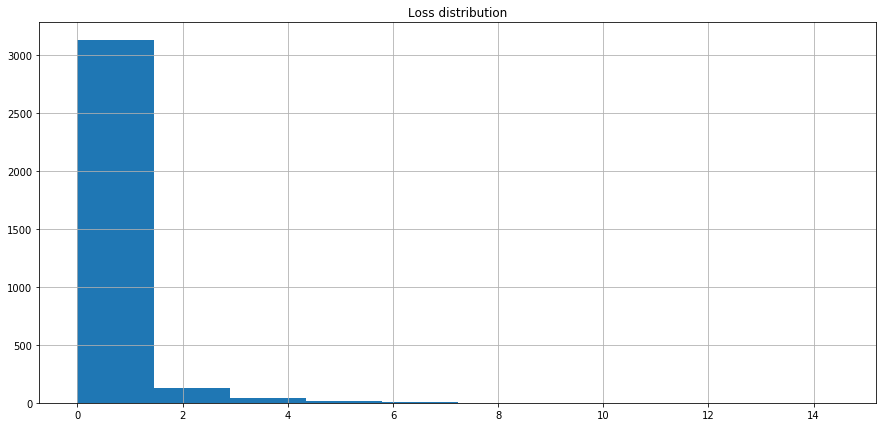

In [545]:
plt.figure(figsize=(15, 7))
plt.title('Loss distribution')
plt.hist(loss.values)
plt.grid()
plt.show()

In [546]:
test_error = MSE(predictions, y_test)
test_error

0.3926073491191336

In [547]:
r2_score(y_test, predictions)

0.6041306604556862

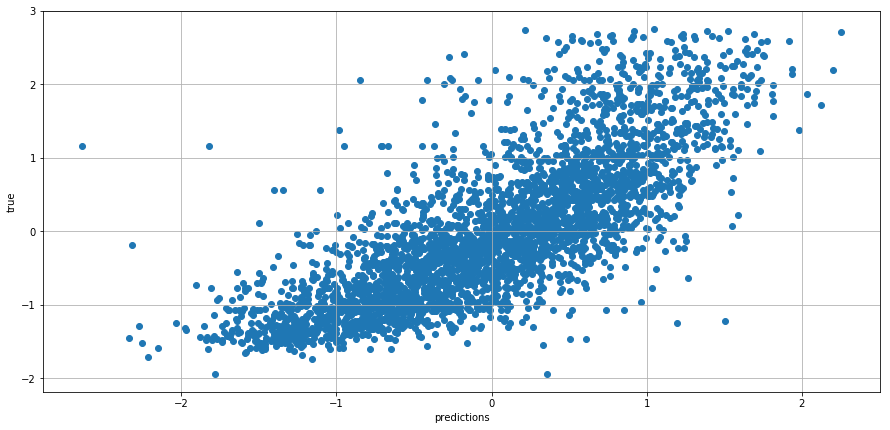

In [548]:
plt.figure(figsize=(15, 7))
plt.scatter(predictions, y_test)
plt.xlabel("predictions")
plt.ylabel("true")
plt.grid()
plt.show()

### Fourth dataset

In [549]:
zscore_norm_reduced_dataset = zscore_norm_reduced_dataset.sample(frac=1).reset_index(drop=True)
x_train, x_test, y_train, y_test = split_dataset(zscore_norm_reduced_dataset)

In [550]:
ridge_regressor.fit(x_train, y_train, 0.1)
ridge_regressor.w

array([-0.61720028, -0.61855826,  0.10771268, -0.23637934,  0.45458263,
       -0.30568301,  0.10271841,  0.63314412,  0.15663553])

In [551]:
predictions = ridge_regressor.predict(x_test)
predictions[:10]

12649   -2.010516
1192     0.105771
12704    1.089040
4411     1.489742
864     -0.018110
13392    0.041404
3336     0.328079
2955    -0.450430
13940   -1.251229
13061   -0.211817
dtype: float64

In [552]:
loss = square_loss(predictions, y_test)

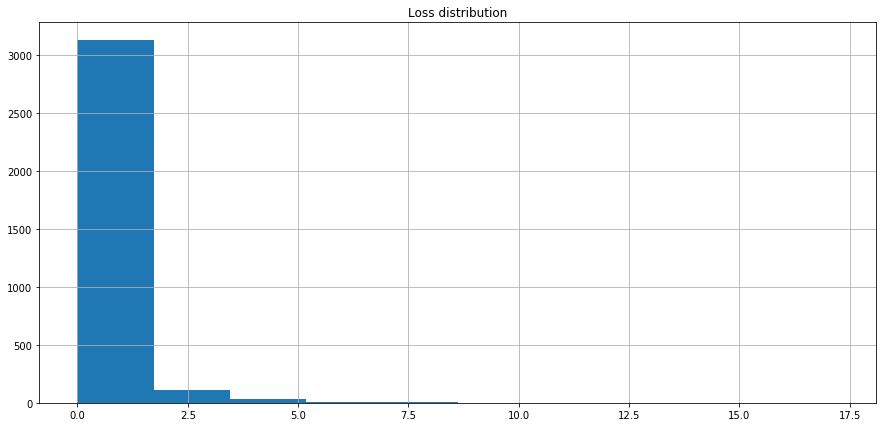

In [553]:
plt.figure(figsize=(15, 7))
plt.title('Loss distribution')
plt.hist(loss.values)
plt.grid()
plt.show()

In [554]:
test_error = MSE(predictions, y_test)
test_error

0.4150754547423494

In [555]:
r2_score(y_test, predictions)

0.583769671432966

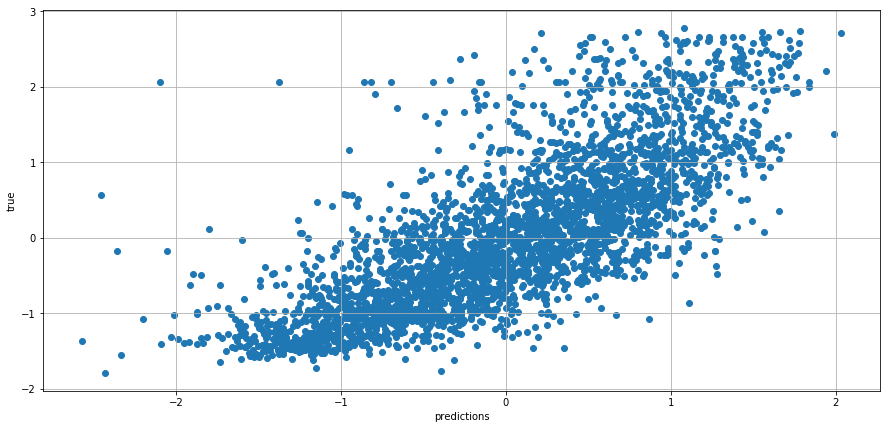

In [556]:
plt.figure(figsize=(15, 7))
plt.scatter(predictions, y_test)
plt.xlabel("predictions")
plt.ylabel("true")
plt.grid()
plt.show()

We notice a relevant difference in test error between the first two datasets with respect to the last twos, which reveals that min max normalization produces better result than z-score.
For what it concerns the replacement of missing values, we notice very little difference.

# Second part: analysis

We are dealing with a learning problem $(D, l)$ where $l$ is the square loss:

- Let $h(S)$ be the prediction of predictor $h$ on training set $S$
- Let $l_D(h(S))$ be the risk of $h(S)$
- Let $E[l_D(h)]$ be the expected risk of $h(S)$ where the expectation is with respect to the random draw of training set $S$

Hence, $E[l_D(h)]$ measures the performance of $h$ on a random training set whereas $l_D(h(S))$ measures the performance of $h$ when the training set is $S$

## K-fold cross validation

We would like to estimate $E[l_D(h)]$ to see, in general, the goodness of our predictor; in order to do this, we can use k-fold cross validation:  
let $S$ be the entire dataset, we partition $S$ in $K$ subsets (called folds) $D_1, D_2, ..., D_K$ of size $m/K$ each where $m$ is the size of $S$ and we use $S^{(k)}$ as <b>training part</b> with $S^{(k)} \equiv S \setminus D_k$ where $D_k$ is the <b>testing part</b>;
we iterate this process for $k = 1 ... K$.

In [559]:
def cross_validation(dataset, K, alfa):   
    scores = []
    
    kf = KFold(n_splits = K, shuffle = True)
    
    for train_i, test_i in kf.split(dataset):
        
        X, y = simple_split(dataset)
        
        x_train, x_test = X.iloc[train_i], X.iloc[test_i]
        y_train, y_test = y.iloc[train_i], y.iloc[test_i]

        # learning with training part
        ridge_regressor.fit(x_train, y_train, alfa)

        # testing with testing part
        result = ridge_regressor.predict(x_test)
        scores.append(MSE(result, y_test))

    return scores

We try $K = 5$

Now let's compare the cv estimate for all 4 datasets we had before

In [567]:
cv_1 = np.mean(cross_validation(min_max_norm_dataset, K, 0.1))

cv_2 = np.mean(cross_validation(min_max_norm_reduced_dataset, K, 0.1))

cv_3 = np.mean(cross_validation(zscore_norm_dataset, K, 0.1))

cv_4 = np.mean(cross_validation(zscore_norm_reduced_dataset, K, 0.1))

print(cv_1, cv_2, cv_3, cv_4)

0.01835976416136082 0.01835931024142585 0.39155096784446847 0.3911491198953156


## Dependence of the cross-validated risk estimate on the parameter alpha

For simplicity, let's consider only one dataset, we will choose the one that showed the best performance with $ \alpha = 0.1$

We will test 5000 values for $\alpha$, from 0.1 to 499 with a step of 0.1

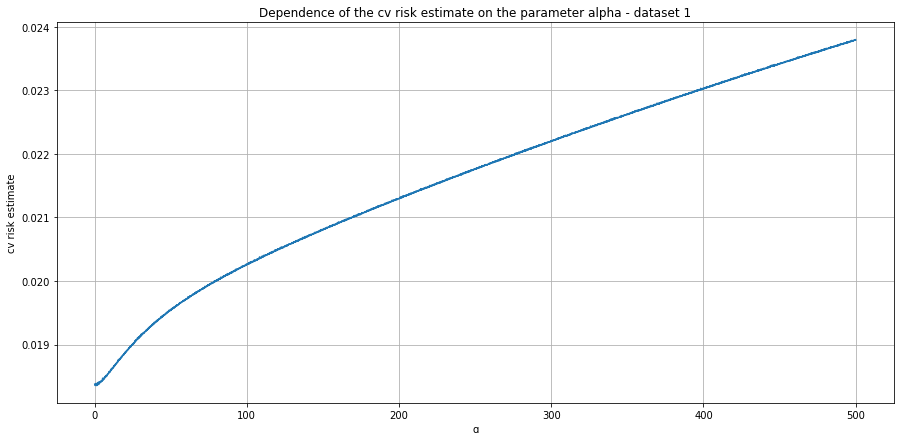

In [492]:
cv_scores = []
alfas = np.linspace(0.1, 500, 5000)

for i in alfas:
    cv_scores.append(np.mean(cross_validation(min_max_norm_dataset, 5, i)))
    
plt.figure(figsize=(15, 7))
plt.title('Dependence of the cv risk estimate on the parameter alpha - dataset 1')
plt.plot(alfas, cv_scores)
plt.xlabel("ɑ")
plt.ylabel("cv risk estimate")
plt.grid()
plt.show()

From this plot we can conclude that the cv risk estimate increseas monotonically for $\alpha \rightarrow \infty$

Let's study the behavior of the risk estimate with the other 3 datasets

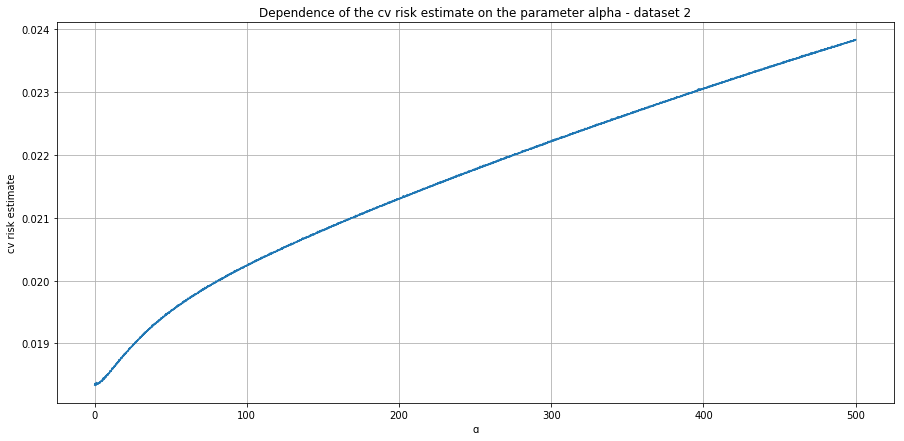

In [493]:
cv_scores = []
alfas = np.linspace(0.1, 500, 5000)

for i in alfas:
    cv_scores.append(np.mean(cross_validation(min_max_norm_reduced_dataset, 5, i)))
    
plt.figure(figsize=(15, 7))
plt.title('Dependence of the cv risk estimate on the parameter alpha - dataset 2')
plt.plot(alfas, cv_scores)
plt.xlabel("ɑ")
plt.ylabel("cv risk estimate")
plt.grid()
plt.show()

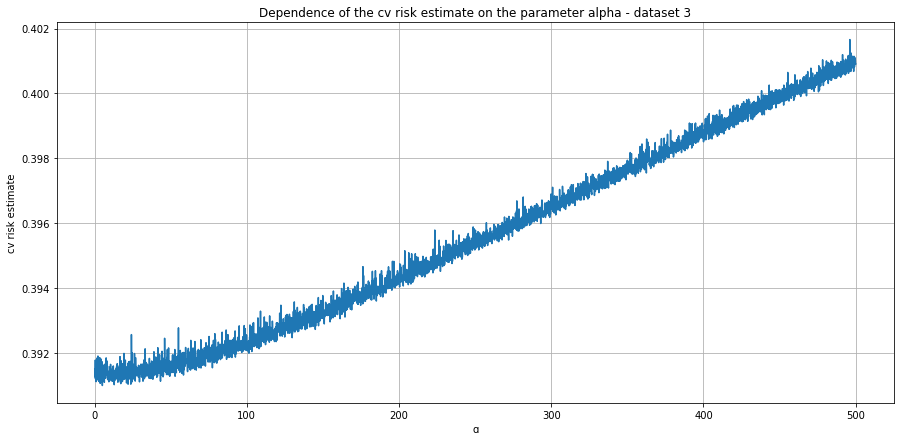

In [494]:
cv_scores = []
alfas = np.linspace(0.1, 500, 5000)

for i in alfas:
    cv_scores.append(np.mean(cross_validation(zscore_norm_dataset, 5, i)))
    
plt.figure(figsize=(15, 7))
plt.title('Dependence of the cv risk estimate on the parameter alpha - dataset 3')
plt.plot(alfas, cv_scores)
plt.xlabel("ɑ")
plt.ylabel("cv risk estimate")
plt.grid()
plt.show()

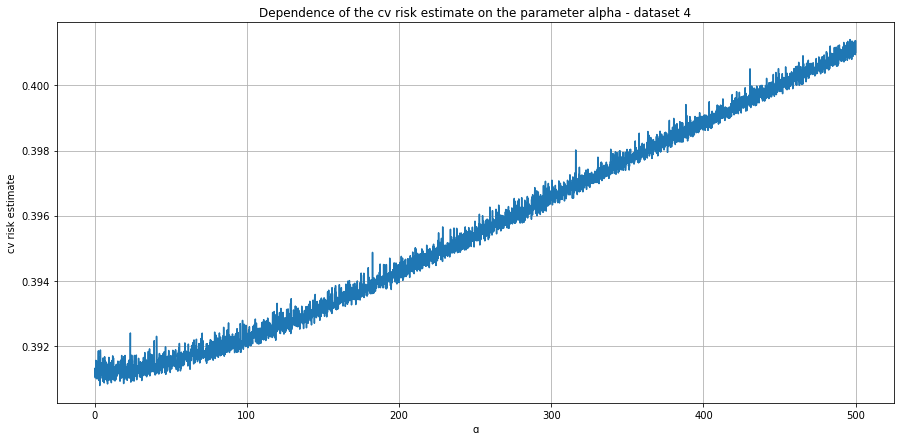

In [495]:
cv_scores = []
alfas = np.linspace(0.1, 500, 5000)

for i in alfas:
    cv_scores.append(np.mean(cross_validation(zscore_norm_reduced_dataset, 5, i)))
    
plt.figure(figsize=(15, 7))
plt.title('Dependence of the cv risk estimate on the parameter alpha - dataset 4')
plt.plot(alfas, cv_scores)
plt.xlabel("ɑ")
plt.ylabel("cv risk estimate")
plt.grid()
plt.show()

This means that there is a dependence of positive linear relationship between cv risk estimate and parameter alpha, in order to confirm this let's compute the correlation coefficient (this is the last dataset):

In [496]:
pearsonr(alfas, cv_scores)[0]

0.9953337289433818

This is highly confirmed by the Pearson coefficient.

After this analysis we try to do ridge regression with $\alpha = 0.001$ and see what happens

In [497]:
cv_1 = np.mean(cross_validation(min_max_norm_dataset, K, 0.001))

cv_2 = np.mean(cross_validation(min_max_norm_reduced_dataset, K, 0.001))

cv_3 = np.mean(cross_validation(zscore_norm_dataset, K, 0.001))

cv_4 = np.mean(cross_validation(zscore_norm_reduced_dataset, K, 0.001))

print(cv_1, cv_2, cv_3, cv_4)

0.01836686920009658 0.018347027444077287 0.3912230128050655 0.39111886971689586


## Using PCA

In [498]:
def prediction_with_PCA(alfa, x_train, y_train, x_test, y_test):
    pca = decomposition.PCA(n_components=7)
    pca.fit(x_train)
    x_train_pca = pca.transform(x_train)
    x_test_pca = pca.transform(x_test)
    ridge_regressor.fit(x_train_pca, y_train, alfa)
    predictions = ridge_regressor.predict(x_test_pca)
    test_error = MSE(predictions, y_test)
    return test_error

Now we can update our previous function of cross correlation by adding the PCA procedure

In [499]:
def cross_validation_with_PCA(dataset, K, alfa):   
    scores = []
    
    kf = KFold(n_splits = K, shuffle = True)
    
    for train_i, test_i in kf.split(dataset):
        
        X, y = simple_split(dataset)
        
        x_train, x_test = X.iloc[train_i], X.iloc[test_i]
        y_train, y_test = y.iloc[train_i], y.iloc[test_i]

        # learning with training part
        ridge_regressor.fit(x_train, y_train, alfa)

        # testing with testing part
        # UPDATE
        pca_score = prediction_with_PCA(alfa, x_train, y_train, x_test, y_test)        
        
        scores.append(pca_score)

    return scores

In [500]:
cv_1 = np.mean(cross_validation_with_PCA(min_max_norm_dataset, K, 0.001))

cv_2 = np.mean(cross_validation_with_PCA(min_max_norm_reduced_dataset, K, 0.001))

cv_3 = np.mean(cross_validation_with_PCA(zscore_norm_dataset, K, 0.001))

cv_4 = np.mean(cross_validation_with_PCA(zscore_norm_reduced_dataset, K, 0.001))

print(cv_1, cv_2, cv_3, cv_4)

0.1883120058443235 0.18816859627639718 0.4060090783118196 0.40656760527556896


## optional: try nested CV to avoid choosing alpha

We are at the end of this notebook, and we want to perform nested cross validation in order to select automatically the best value for $\alpha$.  
From the previous plots we predict that the best value will be the closest value towards 0.

Nested cross validation works by adding at each iteration an inner cross validation where the algorithm tries a range of values for the hyperparameter, in this case $\alpha$, this means that each training part of $(m/K) * (K-1)$ size, is splitted in $L$ folds.    
Consequently, we want $(m/K) * (K-1)$ to be divisible by $L$.

In [501]:
L = 4
print(int(m/K) * (K-1), L)

13144 4


In [502]:
def nested_cross_validation(dataset, K, L, alfas):   
    best_result = 1000000000000
    best_alfa = 10000000000000
    scores = []
    
    kf = KFold(n_splits = K, shuffle = True)
    
    for train_i, test_i in kf.split(dataset):
        kf = KFold(n_splits = L, shuffle = True)
        
        for inner_train_i, inner_test_i in kf.split(dataset.iloc[train_i]):
            
            inner_X, inner_y = simple_split(dataset)
        
            inner_x_train, inner_x_test = inner_X.iloc[train_i], inner_X.iloc[test_i]
            inner_y_train, inner_y_test = inner_y.iloc[train_i], inner_y.iloc[test_i]
        
            inner_scores = []
                   
            for alf in alfas:
                # learning with training part
                ridge_regressor.fit(inner_x_train, inner_y_train, alf)

                # testing with testing part
                inner_result = ridge_regressor.predict(inner_x_test)
                inner_scores.append(MSE(inner_result, inner_y_test))
                
            average_inner_score = np.mean(inner_scores)
            best_inner_result = min(inner_scores) # the best result
            best_inner_result_position = inner_scores.index(best_inner_result) 
            best_inner_alfa = alfas[best_inner_result_position] # the best alfa
            
            if best_inner_result < best_result: # store the current best result obtained and update it if better
                best_result = best_inner_result
                best_alfa = best_inner_alfa
                
        X, y = simple_split(dataset)
        
        x_train, x_test = X.iloc[train_i], X.iloc[test_i]
        y_train, y_test = y.iloc[train_i], y.iloc[test_i]
                
        # learning with training part
        ridge_regressor.fit(x_train, y_train, best_alfa)

        # testing with testing part
        result = ridge_regressor.predict(x_test)
        scores.append(MSE(result, y_test))

    return scores, best_alfa

Now we can find the best value of $\alpha$ in the range $(0.01 - 20)$ for the four datasets

In [503]:
nest_cv_1, best_alfa = nested_cross_validation(min_max_norm_dataset, 5, 4, np.linspace(0.01, 20, 2000))
nest_cv_1 = np.mean(nest_cv_1)
print(nest_cv_1, best_alfa)

0.01837711501112773 1.9699999999999998


In [504]:
nest_cv_2, best_alfa = nested_cross_validation(min_max_norm_reduced_dataset, 5, 4, np.linspace(0.01, 20, 2000))
nest_cv_2 = np.mean(nest_cv_2)
print(nest_cv_2, best_alfa)

0.018360458275648313 0.01


In [505]:
nest_cv_3, best_alfa = nested_cross_validation(zscore_norm_dataset, 5, 4, np.linspace(0.01, 20, 2000))
nest_cv_3 = np.mean(nest_cv_3)
print(nest_cv_3, best_alfa)

0.3917396460718116 0.35999999999999993


In [506]:
nest_cv_4, best_alfa = nested_cross_validation(zscore_norm_reduced_dataset, 5, 4, np.linspace(0.01, 20, 2000))
nest_cv_4 = np.mean(nest_cv_4)
print(nest_cv_4, best_alfa)

0.3909849780023845 0.01


And we finally confirm that the best value is the closest one towards 0.

# Consistency with existing libraries

With the aim of validating the work done let's import the existing libraries that have been developed in this branch and let's see if the results are consistent

In [507]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate

ridge = Ridge(alpha = 0.1)

min_max_norm_dataset = min_max_norm_dataset.sample(frac=1).reset_index(drop=True)

x_train, x_test, y_train, y_test = split_dataset(min_max_norm_dataset) 
ridge.fit(x_train, y_train)
results = ridge.predict(x_test)
print("MSE: ", MSE(results, y_test))

X, y = simple_split(min_max_norm_dataset)
print("CV: ", - np.mean(cross_validate(ridge, X, y, scoring = "neg_mean_squared_error")['test_score']))

print("")

min_max_norm_reduced_dataset = min_max_norm_reduced_dataset.sample(frac=1).reset_index(drop=True)

x_train, x_test, y_train, y_test = split_dataset(min_max_norm_reduced_dataset) 
ridge.fit(x_train, y_train)
results = ridge.predict(x_test)
print("MSE: ", MSE(results, y_test))

X, y = simple_split(min_max_norm_reduced_dataset)
print("CV: ", - np.mean(cross_validate(ridge, X, y, scoring = "neg_mean_squared_error")['test_score']))

print("")

zscore_norm_dataset = zscore_norm_dataset.sample(frac=1).reset_index(drop=True)

x_train, x_test, y_train, y_test = split_dataset(zscore_norm_dataset) 
ridge.fit(x_train, y_train)
results = ridge.predict(x_test)
print("MSE: ", MSE(results, y_test))

X, y = simple_split(zscore_norm_dataset)
print("CV: ", - np.mean(cross_validate(ridge, X, y, scoring = "neg_mean_squared_error")['test_score']))

print("")

zscore_norm_reduced_dataset = zscore_norm_reduced_dataset.sample(frac=1).reset_index(drop=True)

x_train, x_test, y_train, y_test = split_dataset(zscore_norm_reduced_dataset) 
ridge.fit(x_train, y_train)
results = ridge.predict(x_test)
print("MSE: ", MSE(results, y_test))

X, y = simple_split(zscore_norm_reduced_dataset)
print("CV: ", - np.mean(cross_validate(ridge, X, y, scoring = "neg_mean_squared_error")['test_score']))

MSE:  0.017585942859816375
CV:  0.017617167638276737

MSE:  0.017922253313669746
CV:  0.01759850572515527

MSE:  0.38870638431061005
CV:  0.3912863558244882

MSE:  0.38455084746257784
CV:  0.391143373856468
